In [1]:
# import required libraries to manage data and visualize trends
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import bokeh as bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter

In [3]:
# import file for use of plotting trends and running models against
total_path = Path('../data/total_data.csv')
total_data_visual = pd.read_csv(total_path)
total_data_visual = total_data_visual.dropna(subset=['Total_Sales', 'Total_Gallons'])
total_data_visual[['Total_Sales', 'Total_Gallons']] = total_data_visual[['Total_Sales', 'Total_Gallons']].astype(int)
total_data_visual['date'] = pd.to_datetime(total_data_visual['date'])
total_data_visual.set_index('date', inplace= True)
display(total_data_visual.head())
display(total_data_visual.tail())

,Total_Sales,Total_Gallons
date,,
2007-11-26,4697,148
2007-12-03,3233,88
2007-12-10,4526,133
2007-12-17,7291,250
2007-12-24,12813,313


,Total_Sales,Total_Gallons
date,,
2024-04-29,54504,1272
2024-05-06,80744,1835
2024-05-13,70166,1651
2024-05-20,67588,1536
2024-05-27,40259,843


In [4]:
total_data_visual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2007-11-26 to 2024-05-27
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Total_Sales    990 non-null    int32
 1   Total_Gallons  990 non-null    int32
dtypes: int32(2)
memory usage: 15.5 KB


Boken Trend Visualization - to show how sales and gallons progrossed over time data exists
Can be useful in identifying trends or patterns where they may exist

In [16]:
# use of Bokeh library to plot our initial trend line for visual review
output_notebook()
# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(total_data_visual)

# Create a figure
p = figure(x_axis_type='datetime', title='Total Stores Sales and Gallons Over Time', width = 1300, height = 500)
# p.line(x='date', y='Sales', source=source, line_width=2, legend_label='Sales', color='blue')
p.circle(x='date', y='Total_Sales', source=source, size=8, color='blue', legend_label='Total Sales')
p.line(x='date', y='Total_Gallons', source=source, line_width=2, legend_label='Total Gallons', color='green')
# p.circle(x='date', y='Gallons', source=source, size=8, color='green', legend_label='Gallons')

# Customize the plot
p.legend.location = 'top_left'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Sales / Gallons'
p.yaxis.formatter = NumeralTickFormatter(format="0,0")
# p.grid.grid_line_alpha = 0.3

# Show the plot
show(p)

Loading BokehJS ...

In [17]:
# export image to be used in powerpoint
from bokeh.io import export_png
export_png(p, filename='../images/total_stores.png')

'c:\\group project 2\\project-2-group-3\\images\\total_stores.png'

Use of Lag Plot to reflect any identifiable correlation or patterns in the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


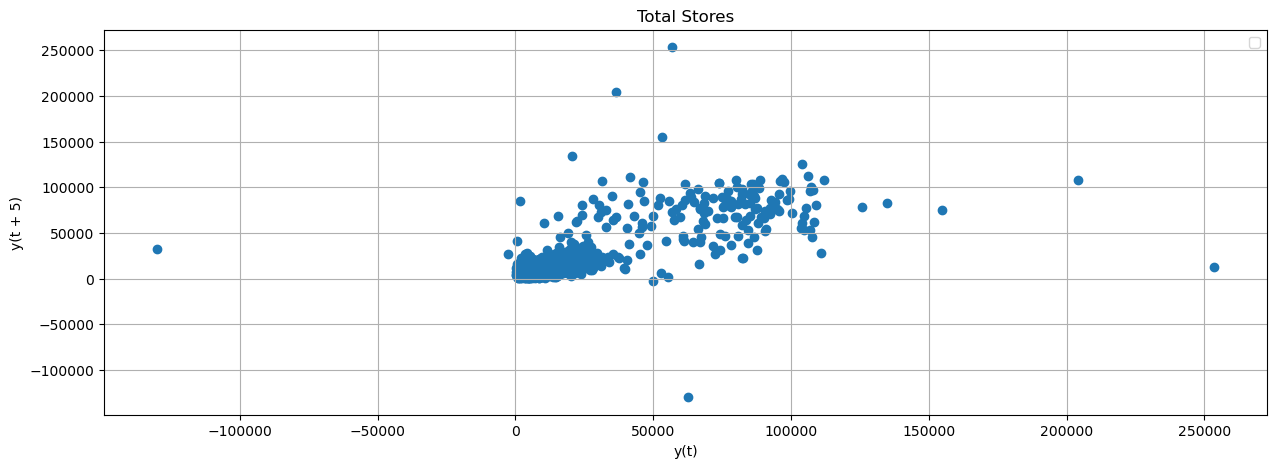

In [14]:
# Lag Plot to show patterns or any correlations
from pandas.plotting import lag_plot
fig = plt.figure(figsize=(15, 5))
lag_plot(total_data_visual['Total_Sales'], lag=5)
plt.title('Total Stores')
plt.grid(True)
plt.legend();

Use of GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to show volatility forecasts for our sales data

In [9]:
# import supporting library to run GARCH anaylsis
from arch import arch_model
from sklearn.preprocessing import StandardScaler

In [7]:
# build dataframe specific to run model on
total_data_model = pd.read_csv(total_path)
total_data_model = total_data_model.dropna(subset=['Total_Sales', 'Total_Gallons'])
total_data_model[['Total_Sales', 'Total_Gallons']] = total_data_model[['Total_Sales', 'Total_Gallons']].astype(int)
total_data_model['date'] = pd.to_datetime(total_data_model['date'])
total_data_model.set_index('date', inplace= True)
display(total_data_model.head())
display(total_data_model.tail())

,Total_Sales,Total_Gallons
date,,
2007-11-26,4697,148
2007-12-03,3233,88
2007-12-10,4526,133
2007-12-17,7291,250
2007-12-24,12813,313


,Total_Sales,Total_Gallons
date,,
2024-04-29,54504,1272
2024-05-06,80744,1835
2024-05-13,70166,1651
2024-05-20,67588,1536
2024-05-27,40259,843


In [10]:
# scale sales data to better fit model
scaler = StandardScaler()
total_data_model['Scaled'] = scaler.fit_transform(total_data_model['Total_Sales'].values.reshape(-1, 1))

In [11]:
# Fit GARCH(1,1) model
garch_model = arch_model(total_data_model['Scaled'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -264.323
Distribution:                  Normal   AIC:                           536.647
Method:            Maximum Likelihood   BIC:                           556.238
                                        No. Observations:                  990
Date:                Mon, Jun 10 2024   Df Residuals:                      989
Time:                        11:39:43   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.5317  7.977e-03    -66.656      0.000 [ -0.547, -0.51

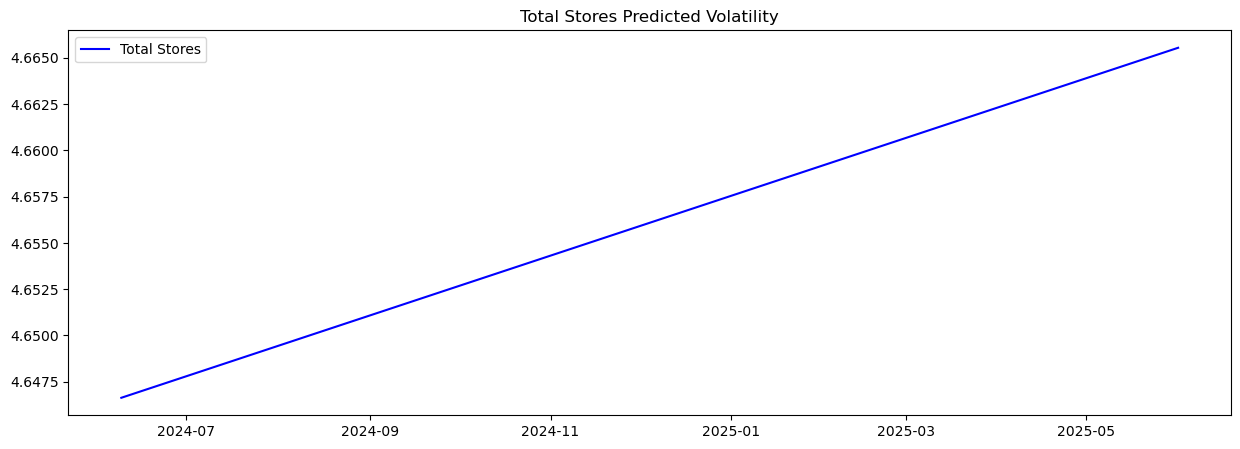

In [15]:
# Make volatility predictions
forecast_horizon = 52  # Predict the next 52 weeks
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract predicted volatility
predicted_volatility = garch_forecast.variance.values[-1, :]

# Future predictions dataframe
last_date = total_data_model.index[-1]
pred_dates = pd.date_range(start=last_date, periods=forecast_horizon+1, freq='W')[1:]
pred_df = pd.DataFrame(predicted_volatility, index=pred_dates, columns=['Predicted_Volatility'])

# Plot the predicted volatility
plt.figure(figsize=(15, 5))
plt.plot(pred_df, label='Total Stores', color='blue')
plt.title('Total Stores Predicted Volatility')
plt.legend()
plt.show()